<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(adversarial_patch.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Adversarial Patch  

### Lab Objectives:  
- Learn about adversarial patch
- Leverage tools such as ART for generating adversarial patches  
- Seeing how a label may be flipped as a result of the adversarial patch
- Save and reload the adversarial patch 


### Step 1: 

In [1]:
# Import the libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import art
from art.attacks.evasion import AdversarialPatchPyTorch
from art.estimators.classification import PyTorchClassifier

import netron


In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torchvision version used:  {torchvision.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'ART version used:  {art.__version__}')
print(f'Netron version used:  {netron.__version__}')


Torch version used:  2.7.1+cu128
Torchvision version used:  0.22.1+cu128
Numpy version used:  2.1.3
ART version used:  1.20.1
Netron version used:  8.4.4


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Setup the transform
transform = transforms.Compose(transforms=[transforms.ToTensor()])

# Get the train dataset
train_set = torchvision.datasets.MNIST(root=r'/tmp/', train=True, download=True, transform=transform)

# Setup the train dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 6.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.48MB/s]


In [5]:
# Setup the test data
test_set = torchvision.datasets.MNIST(root=r'/tmp/', train=False, download=True,  transform=transform)

# Setup the test dataloader
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)

### Step 2:  
Create a sample model   

In [6]:
# Define a simple network
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=128, bias=True),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=128, out_features=10),

        )
    
    def forward(self, x):
        x = self.layers(x)
        return x


In [7]:
# Set a random seed
torch.manual_seed(10)

# Setup the model
model = Net().to(device=device)

# Confirm the model is working as expecting
model(next(iter(train_loader))[0].to(device)).shape

torch.Size([64, 10])

Setup the netrorn environment 
$ netron --host 0.0.0.0 --port 8888  

The go to your browser and type: http://127.0.0.1:8888/   

Finally, drag and drop the model file into your environment. You should see something like 
<img src='./graphics/netron_computation_graph.png'>

### Step 3:  
Train the model. No need for any exotic training. The objective is not build a model that can be deployed but instead to build a model we can target with adversarial patch.   

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

print(f'Training the model ... ')
for epoch in range(50):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # For testing
        break


print(f'Finished training the model ... ')

Training the model ... 
Finished training the model ... 


In [9]:
# Get the sample data from the test set
sample_X, sample_y = next(iter(test_loader))
sample_X.shape, sample_y

(torch.Size([1, 1, 28, 28]), tensor([7]))

In [10]:
# Make a prediction on the sample
model(sample_X.to(device)).argmax(dim=-1)

tensor([7], device='cuda:0')

In [11]:
# Let us create a target label
# Let us try to see if we can get the patch to flip the label to 1
target_label = np.array([0])
target_label

array([0])

In [12]:
# Convert the sample to numpy
sample_X, sample_y = sample_X.numpy(), sample_y.numpy()
type(sample_X), type(sample_y)

(numpy.ndarray, numpy.ndarray)

With the data and model in place, we can now move  

### Step 4:  

In [13]:
# Setup the art classifier
art_adv_patch_clf = PyTorchClassifier(
    model=model, 
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=sample_X.shape[1:],
    nb_classes=10, 
    clip_values=(0.0, 1.0),
    device_type=device,
)

art_adv_patch_clf

art.estimators.classification.pytorch.PyTorchClassifier(model=ModelWrapper(
  (_model): Net(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=2304, out_features=128, bias=True)
      (8): ReLU()
      (9): Linear(in_features=128, out_features=10, bias=True)
    )
  )
), loss=CrossEntropyLoss(), optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), input_shape=(1, 28, 28), nb_classes=10,

In [14]:
# Setup the art attack
# For the attack, you can experiment some of these hyperparameters
art_adv_patch_attack = AdversarialPatchPyTorch(
    estimator=art_adv_patch_clf,
    patch_shape=(1,15,15),  # Try a different patch size
    rotation_max=22.5,      # Try a different rotation maximum
    scale_min=0.1,
    scale_max=0.3,
    learning_rate=10.0,     # Try a different learning rate
    max_iter=1000,          # Increase or reduce the number of iterations to see the effect
    targeted=True,          # make this a targeted attack
    distortion_scale_max=.3,# Try a different distortion_scale_max
    batch_size=1, 
    verbose=True,

)
art_adv_patch_attack

AdversarialPatchPyTorch(rotation_max=22.5, scale_min=0.1, scale_max=0.3, distortion_scale_max=0.3, learning_rate=10.0, max_iter=1000, batch_size=1, patch_shape=(1, 15, 15), targeted=True, summary_writer=None, verbose=True, )

In [15]:
# Generate the adversarial patch
# adversrial_patch returns the actual patch
# mask shows where the patch is applied
adv_patch, mask = art_adv_patch_attack.generate(x=sample_X, y=target_label)

#adv_patch, mask

Adversarial Patch PyTorch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# Get the shape of the mask and patch
print(f'Patch shape: {adv_patch.shape}')
print(f'Mask shape: {mask.shape}')

Patch shape: (1, 15, 15)
Mask shape: (1, 15, 15)


### Step 5:  
Visualize our patch  

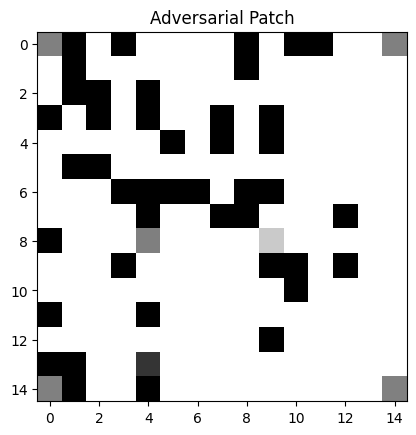

In [17]:
# Visualize the patch
plt.title('Adversarial Patch')
plt.imshow(X=adv_patch.squeeze(), cmap='gray')
plt.show()

In [18]:
# With the patch in place, let us apply it to the image
x_patched = art_adv_patch_attack.apply_patch(x=sample_X, scale=None, patch_external=adv_patch)
x_patched.shape

(1, 1, 28, 28)

In [19]:
# Get the label of the patched image
adv_patch_prediction = art_adv_patch_clf.predict(x_patched).argmax(axis=-1)
adv_patch_prediction

array([7])

Ok, we did not get it to be a 0 but we did manage to get to change it from a 7?  This statement is not true as we still have a 7 above. However, in my tests, I have seen this value changed to other classes. I was not sure which combination gave me the result I was expecting. Anyhow that is not a major concern at this time. 

In [20]:
# Convert the tensors to images
def imshow(img_tensor, title, label=None):
    img = img_tensor.squeeze()
    plt.title(label=f'{title} : {label}')
    plt.imshow(X=img, cmap='gray')
    plt.axis('off')

By default, the patch is going to be in random positions. If we want we can set the patch at a particular location. Let us just keep things simple. You can build on this if you wish. 

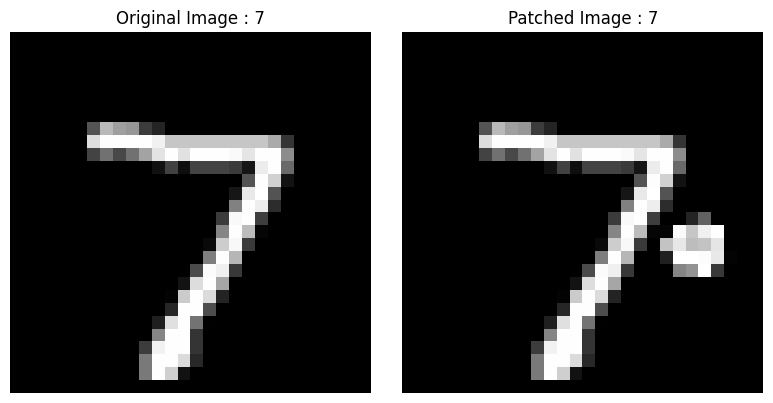

In [21]:
# Let us now view the original and the patched image
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imshow(torch.tensor(data=sample_X), title='Original Image', label=sample_y.item())

plt.subplot(1,2,2)
imshow(torch.tensor(data=x_patched), 'Patched Image', label=adv_patch_prediction.item())

plt.tight_layout()
plt.show()

### Step 6:  
Save the patch   

In [22]:
# We can save the patch 
# First let us confirm that it is a numpy array
x_patched_np = adv_patch if isinstance(adv_patch, np.ndarray) else adv_patch.detach().cpu.numpy()

# Save to disk
np.save(file=r'/tmp/adversarial_patch.npy', arr=x_patched_np)

# Verify the file is saved on the filesystem
!ls /tmp/adversarial_patch.npy

/tmp/adversarial_patch.npy


In [23]:
# Alternatively, we could have saved it as a torch tensor
patch_tensor = torch.tensor(data=x_patched)
torch.save(obj=patch_tensor, f='/tmp/adversarial_patch.pt')

# Verify the file is saved
! ls /tmp/adversarial_patch.pt

/tmp/adversarial_patch.pt


### Step 7:  
With the patch saved, how do we load it?


In [24]:
# Load the saved patch
loaded_adv_patch = np.load(file=r'/tmp/adversarial_patch.npy')
loaded_adv_patch.shape, adv_patch.shape

((1, 15, 15), (1, 15, 15))

In [25]:
# We are just reducing the same sample. 
# We could have used another sample within the dataset
new_patched_sample = art_adv_patch_attack.apply_patch(x=sample_X, scale=None, patch_external=loaded_adv_patch)
new_patched_sample.shape

(1, 1, 28, 28)

In [26]:
# Get the label of the patched image
# I am not sure why the prediction is not the same as above. However, we still achieved our objectives.
loaded_adv_patch_prediction = art_adv_patch_clf.predict(new_patched_sample).argmax(axis=-1)
loaded_adv_patch_prediction

array([7])

In [27]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


### Lab Takeaways:  
- We learnt how to use ART
- We saw that we can create adversarial patches  
- We *should* have been able to force the model to predict the sample as 0, even though it is originally 7. I say *should* have, because I noticed as I ran this attack multiple times, sometimes it changed and sometime it did not. I take it if we manipulate the hyperparameters, we will see different results. 
- While it may not have changed the label above, we should have come away with a solid understanding of what *adversarial patch* is.